In [386]:
pip install --upgrade -q git+https://github.com/huggingface/transformers

Note: you may need to restart the kernel to use updated packages.


In [387]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [388]:
# Se importan librerías necesarias 
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

# Librerías para procesamiento de imágenes
import cv2
import torch
import requests
import numpy as np
from PIL import Image

# Modelos preentrenados para segmentación
import matplotlib.pyplot as plt
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline, AutoModel
from diffusers import StableDiffusionInpaintPipeline

In [389]:
# Clase para representar un rectángulo delimitador en la imagen alrededor de un objeto

@dataclass
class BoundingBox: 
    xmin: int 
    ymin: int
    xmax: int
    ymax: int
    
    # Devuelve una lista con los valores de las variables
     
    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

In [390]:
# Clase que representa un resultado de detección

@dataclass
class DetectionResult:
    score: float                        # Confianza del modelo en la detección del objeto
    label: str                          # Etiqueta del objeto detectado
    box: BoundingBox                    # Coordenadas del rectángulo
    mask: Optional[np.array] = None     # Máscara de segmentación del objeto detectado

    #  Método que toma un diccionario como argumento, que se espera que contenga la información de una detección
    #  Devuelve una instancia de la clase 'DetectionResult'
    
    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))

In [391]:
# Carga una imagen desde una URL o desde el disco

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")
    return image

In [392]:
# Extrae las bounding boxes de las detecciones

def get_boxes(results: List[DetectionResult]) -> List[List[List[float]]]:
    return [[result.box.xyxy for result in results]]

In [393]:
# Convierte las máscaras en listas de arrays numpy

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1).mean(axis=-1)
    masks = (masks > 0).int().cpu().numpy().astype(np.uint8)
    masks = list(masks)  # Lista de máscaras individuales

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            polygon = mask_to_polygon(mask)
            masks[idx] = polygon_to_mask(polygon, mask.shape)

    return masks

In [394]:
# Convierte una máscara binaria en un polígono (contorno más grande)

def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour.reshape(-1, 2).tolist()

In [395]:
# Convierte un polígono en una máscara binaria

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    mask = np.zeros(image_shape, dtype=np.uint8)
    pts = np.array(polygon, dtype=np.int32)
    cv2.fillPoly(mask, [pts], color=(255,))
    return mask

In [396]:
# Devuelve una imagen donde la región de la máscara está en negro y el resto en blanco 

def isolate_mask_region(image: np.ndarray, mask: np.ndarray, invert: bool = False) -> np.ndarray:
    mask = mask.astype(np.uint8)
    if invert:
        mask = cv2.bitwise_not(mask)

    white_background = np.ones_like(image) * 255
    if len(mask.shape) == 2:
        mask_3ch = np.stack([mask]*3, axis=-1)
    else:
        mask_3ch = mask

    result = cv2.bitwise_and(white_background, 255 - mask_3ch)
    return result

In [397]:
# Detecta objetos en una imagen usando Grounding DINO con etiquetas personalizadas

def detect(image: Image.Image, labels: List[str], threshold: float = 0.3, detector_id: Optional[str] = None) -> List[DetectionResult]:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id or "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)
    labels = [label if label.endswith(".") else label + "." for label in labels]
    results = object_detector(image, candidate_labels=labels, threshold=threshold)
    return [DetectionResult.from_dict(result) for result in results]

In [398]:
# Aplica SAM (Segment Anything Model) para generar máscaras de los objetos detectados

def segment(image: Image.Image, detection_results: List[DetectionResult], polygon_refinement: bool = False, segmenter_id: Optional[str] = None) -> List[DetectionResult]:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id or "facebook/sam-vit-base"
    segmentator = AutoModel.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)
    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)
    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask

    return detection_results

In [399]:
""""
    Pipeline completo:
    - Carga la imagen
    - Detecta objetos
    - Segmenta objetos detectados
    - Devuelve la imagen y las detecciones con sus máscaras
"""
def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections

In [ ]:
image_path = "../data/5_image_women_fringe.jpg"
labels = ["a hair"]
threshold = 0.3
detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

In [401]:
# Detectar y segmentar

image_array, detections = grounded_segmentation(
    image=image_path,
    labels=labels,
    threshold=threshold,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)

Device set to use cpu


In [402]:
# Obtener la máscara del cabello (primera detección)
hair_mask = detections[0].mask

In [403]:
# Generar imagen blanco + cabello negro
output_image = isolate_mask_region(image_array, hair_mask, invert=False)

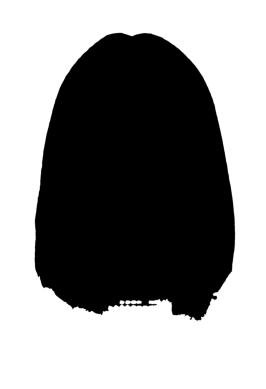

In [404]:
# Mostrar el resultado
plt.imshow(output_image)
plt.axis('off')
plt.show()

In [405]:
image = Image.fromarray(output_image)
image.save("../data/5_mask_grounding_dino.png")